# MTOW and MLAW for aicraft types

This notebook is used to create a file listing the MTWO and the MALW of frequently operated aircraft types.
The data are based on Wikipedia's List of airliners by MTOW (https://en.wikipedia.org/wiki/List_of_airliners_by_maximum_takeoff_weight), the FAA Aircraft Characteristics Database (https://www.faa.gov/airports/engineering/aircraft_char_database) (Last updated: Friday, October 13, 2023) and the Wikipedia article abput the Cessna Citation family https://en.wikipedia.org/wiki/Cessna_Citation_family.
As we wanted all aircraft types to be represented by an ICAO code, we also made use of Wikipedia's List of aircraft type designators https://en.wikipedia.org/wiki/List_of_aircraft_type_designators.
The Wikipedia lists were converted to .csv-files by use of https://wikitable2csv.ggor.de/ (see also https://github.com/gambolputty/wikitable2csv?tab=readme-ov-file). 

Author: Dennis Schorn (dennis.schorn@mail.de)
Current version from 2024-09-23

In [1]:
# Import libraries
import pandas as pd
import numpy as np

#### Create a DataFrame Containing the MTOW and MLAW based on Wikipedia's data

In [2]:
# Read in type_designators.csv
designators_raw = pd.read_csv('type_designators.csv')

# Remove IATA Code from designators and rename 'Model' to 'Type' for consistency
designators = designators_raw.drop(columns=['IATA type code'])
designators.rename(columns={' Model':'Type'}, inplace=True)

# Keep only the lines with the shortest model string
designators = designators.loc[designators.groupby('ICAO code')['Type'].idxmin()].reindex()

# Read in wikipedia_list_of_airliners_by_mtow.csv
mtow_data_raw = pd.read_csv('wikipedia_list_of_airliners_by_mtow.csv')
mtow_data = mtow_data_raw.drop(columns=['TOR [m]', 'LR [m]', 'ICAO category']) 
mtow_data.sort_values('Type')

# Create a new data frame adding 'ICAO code' to mtow_data based on the Type column

# Merge the two data frames on 'Type' and 'key_1' columns
mtow_data = pd.merge(mtow_data, designators, left_on=['Type', mtow_data.groupby('Type').cumcount()], right_on=['Type', designators.groupby('Type').cumcount()])
mtow_data.sort_values('Type', inplace=True)

# Drop the 'key_1' column
mtow_data.drop(columns=['key_1'], inplace=True)

# Remove separators from MTOW column and convert it to integer
mtow_data['MTOW [kg]'] = mtow_data['MTOW [kg]'].apply(lambda x: x.replace(',', ''))
mtow_data['MTOW [kg]'] = mtow_data['MTOW [kg]'].apply(lambda x: x.replace('.', ''))
mtow_data['MTOW [kg]'] = mtow_data['MTOW [kg]'].astype(int)

# Convert MLW from tonnes to kg
mtow_data['MLW [tonnes]'] = (mtow_data['MLW [tonnes]']*1000).astype(int)

# Rename MLW column to MLAW [kg] and ICAO code to aircraft_type
mtow_data.rename(columns={'MLW [tonnes]':'mlw'}, inplace=True)
mtow_data.rename(columns={'ICAO code':'aircraft_type'}, inplace=True)
mtow_data.rename(columns={'MTOW [kg]':'mtow'}, inplace=True)

# Reorder columns
mtow_data = mtow_data[['aircraft_type', 'mtow', 'mlw']]

#### Create a DataFrame Containing the MTOW and MLW based on the FAA Aircraft Characteristics Database

In [3]:
# Read the FAA .csv file and convert it to a DataFrame
faa_weights = pd.read_csv('FAA_weights.csv', sep=';')
faa_weights = faa_weights.dropna()

# Remove separators
faa_weights['MTOW_lb'] = faa_weights['MTOW_lb'].apply(lambda x: x.replace('.', ''))
faa_weights['MTOW_lb'] = faa_weights['MTOW_lb'].astype(int)
faa_weights['MLW_lb'] = (faa_weights['MLW_lb']*1000).astype(int)

# Convert MTOW and MLAW in lb to MTOW in kg
faa_weights['mtow'] = (round(faa_weights['MTOW_lb'] * 0.453592 / 10) * 10).astype(int)
faa_weights['mlw'] = (round(faa_weights['MLW_lb'] * 0.453592 / 10) * 10).astype(int)

# Drop unnecessary columns
faa_weights.drop(columns=['MTOW_lb', 'MLW_lb'], inplace=True)

# Keep only the lines with MTOW > 7500 kg
faa_weights = faa_weights[faa_weights['mtow'] > 7500]

# Reset index
faa_weights.reset_index(drop=True, inplace=True)

# Rename columns
faa_weights.rename(columns={'ICAO_Code':'aircraft_type'}, inplace=True)

#### Merge MTOW and MLW based on the Wikipedia's List's data and the FAA data

In [4]:
icao_mtow_mlw = pd.concat([mtow_data, faa_weights], ignore_index=True).drop_duplicates(subset=['aircraft_type']).sort_values('aircraft_type').reset_index(drop=True)

#### Determine usefull categories based on MTOW

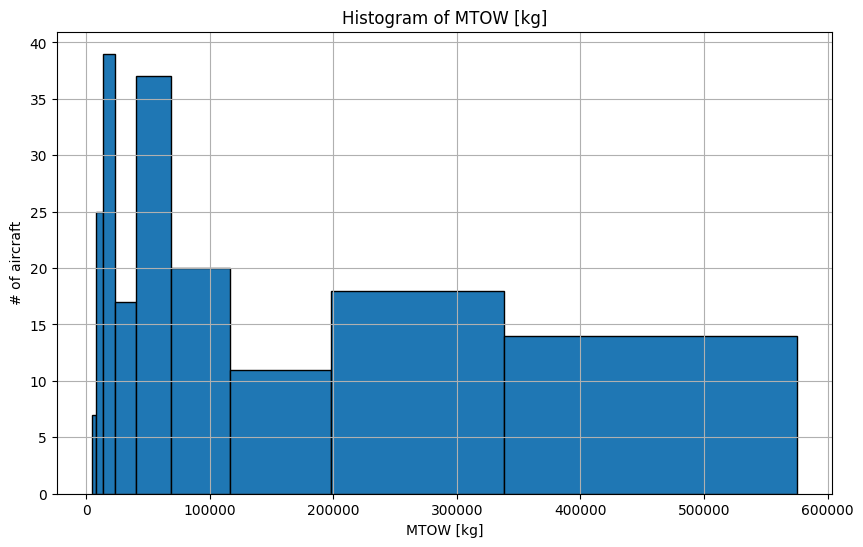

In [5]:
import matplotlib.pyplot as plt

# Introduce logarithmic binning
bins = np.logspace(np.log10(icao_mtow_mlw['mtow'].min()), np.log10(icao_mtow_mlw['mtow'].max()), num=10)
# Create a histogram for MTOW from icao_mtow
plt.figure(figsize=(10, 6))
plt.hist(icao_mtow_mlw['mtow'], bins=bins, edgecolor='black')
#plt.xscale('log')
plt.title('Histogram of MTOW [kg]')
plt.xlabel('MTOW [kg]')
plt.ylabel('# of aircraft')
plt.grid(True)
plt.show()

In [6]:
# Assign bin numbers to each row in icao_mtow
icao_mtow_mlw['mtow_group'] = pd.cut(icao_mtow_mlw['mtow'], bins=bins, labels=False)
icao_mtow_mlw.sort_values('aircraft_type', inplace=True)

# Assign separate mtow_group for A380
icao_mtow_mlw.loc[icao_mtow_mlw['aircraft_type'] == 'A388', 'mtow_group'] = icao_mtow_mlw['mtow_group'].max() + 1

# Save the data frame to a .csv file
icao_mtow_mlw.to_csv('type_mtow_mlw.csv', index=False)

#### Determine the aircraft types that are in the challenge and submission flight list but not in icao_mtow_mlw

In [7]:
fls = pd.read_csv('submission_set.csv')
flc = pd.read_csv('challenge_set.csv')

types_sc = pd.concat([fls['aircraft_type'].drop_duplicates(), flc['aircraft_type'].drop_duplicates()], ignore_index=True).drop_duplicates().reset_index(drop=True)

missing_types = types_sc[~types_sc.isin(icao_mtow_mlw['aircraft_type'])]
print(missing_types)

Series([], Name: aircraft_type, dtype: object)
